In [3]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, nsd_utils, coco_utils
from model_fitting import initialize_fitting 
import argparse
import pandas as pd
import matplotlib

Initializing coco api...
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=16.32s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=16.51s)
creating index...
index created!


In [4]:
subject=1
which_prf_grid=5;
prf_model_index=600;


number of pRFs: 1456
most extreme RF positions:
[2.7755576e-17 0.0000000e+00 2.0000000e-02]
[ 0.7698996  -0.31890285  1.        ]


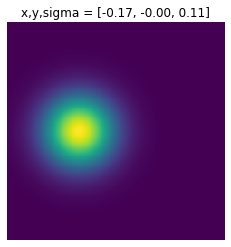

In [5]:
import matplotlib.pyplot as plt
from utils import prf_utils
which_prf_grid=5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)
mm = prf_model_index

x,y,sigma = models[mm,:]
n_pix = 240
prf_2d = prf_utils.gauss_2d(center=[x,y], sd=sigma, patch_size=n_pix)

plt.figure();
plt.pcolormesh(prf_2d)
plt.axis('off')
plt.axis('square')
plt.gca().invert_yaxis()
plt.title('x,y,sigma = [%.2f, %.2f, %.2f]'%(x,y,sigma));

In [8]:
ims2load = np.arange(0,100)
image_data = nsd_utils.get_image_data(subject)
image_data = nsd_utils.image_uncolorize_fn(image_data[ims2load,:,:,:])
# image_data = image_data[ims2use,:,:,:]
n_images = image_data.shape[0]


Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255


In [22]:
labels_folder = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf_grid%d'%(subject, \
                                                                                        which_prf_grid))


fn2load = os.path.join(labels_folder, 'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_model_index))
coco_df = pd.read_csv(fn2load, index_col=0)
cat_labels = np.array(coco_df)[:,12:92]
supcat_labels = np.array(coco_df)[:,0:12]

fn2load = os.path.join(labels_folder, 'S%d_cocolabs_stuff_binary_prf%d.csv'%(subject, prf_model_index))
coco_stuff_df = pd.read_csv(fn2load, index_col=0)
stuff_cat_labels = np.array(coco_stuff_df)[:,16:108]
supcat_stuff_labels = np.array(coco_stuff_df)[:,0:16]


In [10]:
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = \
                coco_utils.get_coco_cat_info(coco_utils.coco_val)

stuff_cat_objects, stuff_cat_names, stuff_cat_ids, stuff_supcat_names, stuff_ids_each_supcat = \
        coco_utils.get_coco_cat_info(coco_utils.coco_stuff_val) 


In [59]:
len(cat_names)

80

In [60]:
len(supcat_names)

12

In [56]:
stuff_cat_labels.shape

(10000, 92)

In [26]:
animate_supcats = [1,9]
inanimate_supcats = [ii for ii in range(len(supcat_names)) if ii not in animate_supcats]

In [40]:
has_animate = np.any(np.array([supcat_labels[:,ii]==1 for ii in animate_supcats]), axis=0)
has_inanimate = np.any(np.array([supcat_labels[:,ii]==1 for ii in inanimate_supcats]), axis=0)

animate_inanimate = np.concateanimatee([has_animate[:,np.newaxis], has_inanimate[:,np.newaxis]], axis=1)

In [41]:
print(np.sum(has_inanimate & has_animate))
print(np.sum(~has_inanimate & has_animate))
print(np.sum(has_inanimate & ~has_animate))
print(np.sum(~has_inanimate & ~has_animate))

3477
2226
3570
727


In [43]:
ims2load = np.arange(100)


image 0 has:
['cat']
['fence', 'tree', 'other']

image 1 has:
['giraffe']
['grass', 'sky-other', 'tree', 'other']

image 2 has:
['person']
['grass', 'other']

image 3 has:
['giraffe']
['building-other', 'fence', 'tree', 'wall-brick', 'other']


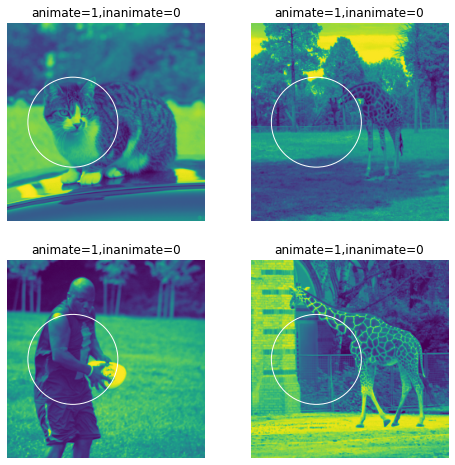

In [47]:
# plot examples - "animate only" patches

ims2use = np.where((animate_inanimate[:,0]==1) & (animate_inanimate[:,1]==0) & \
                   np.isin(np.arange(10000), ims2load))[0]

images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('animate=%d,inanimate=%d'%(animate_inanimate[im,0], animate_inanimate[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])


image 0 has:
['boat']
['tree', 'water-other', 'other']

image 1 has:
['teddy bear']
['carpet', 'floor-marble', 'plant-other', 'textile-other', 'other']

image 2 has:
['kite']
['sky-other', 'other']

image 3 has:
['bottle', 'toilet']
['curtain', 'shelf', 'other']


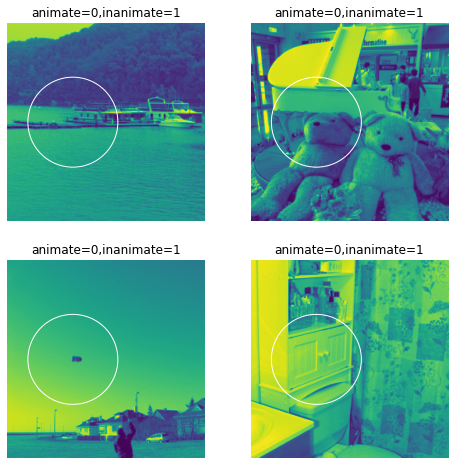

In [48]:
# plot examples - "inanimate only" patches

ims2use = np.where((animate_inanimate[:,0]==0) & (animate_inanimate[:,1]==1) & \
                   np.isin(np.arange(10000), ims2load))[0]
images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('animate=%d,inanimate=%d'%(animate_inanimate[im,0], animate_inanimate[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])


image 0 has:
['person', 'surfboard']
['sea', 'other']

image 1 has:
['person', 'oven']
['cardboard', 'metal', 'other']

image 2 has:
['person', 'surfboard']
['sea', 'other']

image 3 has:
['person', 'surfboard']
['mountain', 'sand', 'sea', 'other']


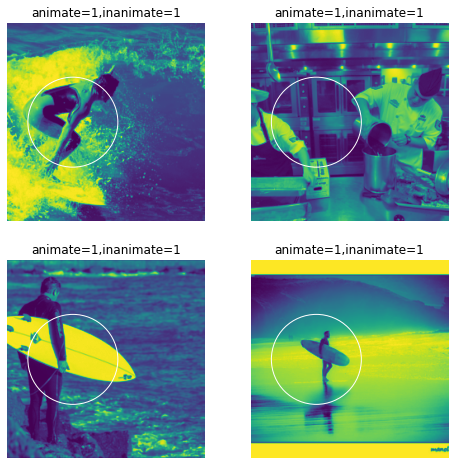

In [50]:
# plot examples - "both"

ims2use = np.where((animate_inanimate[:,0]==1) & (animate_inanimate[:,1]==1) & \
                   np.isin(np.arange(10000), ims2load))[0]
images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('animate=%d,inanimate=%d'%(animate_inanimate[im,0], animate_inanimate[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])


image 0 has:
[]
['furniture-other']

image 1 has:
[]
['clouds', 'tree']

image 2 has:
[]
['clouds', 'metal', 'sea', 'sky-other']

image 3 has:
[]
['furniture-other']


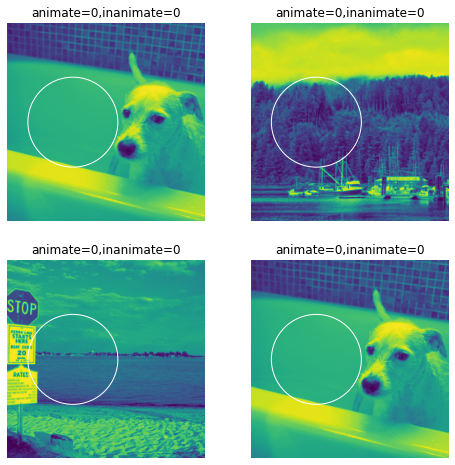

In [51]:
# plot examples - "neither"

ims2use = np.where((animate_inanimate[:,0]==0) & (animate_inanimate[:,1]==0) & \
                   np.isin(np.arange(10000), ims2load))[0]
images2plot = np.random.choice(ims2use,4);

center_in_image = np.array((n_pix/2 + x*n_pix, n_pix/2 - n_pix*y))
size_in_image = 2*sigma*n_pix

plt.figure(figsize=(8,8));

for ii, im in enumerate(images2plot):
    ax = plt.subplot(2,2,ii+1);
    plt.imshow(image_data[im,0,:,:])
    circ = matplotlib.patches.Circle(center_in_image, size_in_image, 
                                                 color = 'w', fill=False)
    ax.add_artist(circ)
    plt.axis('off')
    plt.title('animate=%d,inanimate=%d'%(animate_inanimate[im,0], animate_inanimate[im,1]))
    print('\nimage %d has:'%ii)
    print([cat_names[cc] for cc in range(len(cat_names)) if cat_labels[im,cc]==1])
    print([stuff_cat_names[cc] for cc in range(len(stuff_cat_names)) if stuff_cat_labels[im,cc]==1])